# Model Diagnostics: Statistics vs Machine Learning

In this notebook, we show how different use cases require different model diagnostics.
In short, we compare (statistical) inference and prediction.

As an example, we use a simple linear model for the Munich rent index dataset, which was kindly provided by the authors of [Regression - Models, Methods and Applications 2nd ed. (2021)](https://doi.org/10.1007/978-3-662-63882-8).
This dataset contains monthy rents in EUR (`rent`) for about 3000 apparments in Munich, Germany, from 1999.
The apparments have several features such as living area (`area`) in squared meters, year of construction (`yearc`), quality of location (`location`, 0: average, 1: good, 2: top), quality of bath rooms (`bath`, 0:standard, 1: premium), quality of kitchen (`kitchen`, 0: standard, 1: premium), indicator for central heating (`cheating`).

The target variable is $Y=\text{rent}$ and the goal of our model is to predict the mean rent, $E[Y]$.

Disclaimer: Before presenting the use cases, let me clearly state that I am not in the appartment rent business and everything here is merely for the purpose of demonstating statistical good practice.

**Inference**

The first use case is about inference of the effect of the features.
Imagine the point of view of an investor who wants to know whether the installation of a central heating is worth it (financially).
To lay the ground on which to base a decision, a statistician must have answers to:
- What is the *effect* of the variable `cheating` on the rent.
- Is this effect statistically significant?

**Prediction**

The second use case is about prediction.
This time, we take the point of view of someone looking out for a new appartment to rent.
In order to know whether the proposed rent by the landlord is about right or improper (too high), a reference value would be very convenient.
One can either ask the neighbors or ask a model to predict the rent of the appartment in question.

## 1. Imports, Data, Fit

Before answering the above questions and doing some key diagnostics, we load the data and prepare a linear model.
Note that we use `GeneralizedLinearRegressor` from the python package [`glum`](https://glum.readthedocs.io/) as model.
We could as well have chosen other implementations like `statsmodels.OLS`.
This way, we have to implement the residual diagnostics ourselves which makes it clear what is plotted.

In [1]:
import glum  # 3.1.2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  # 2.2.3
import scipy
import seaborn as sns
# import sklearn  # 1.6.1
from model_diagnostics.calibration import compute_bias, plot_bias, plot_marginal, plot_reliability_diagram  # 1.4.2
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# sklearn.set_config(transform_output="polars")
# Note that glum does not (yet) like polars, grrrr!!

In [2]:
# munich-rent-index-1999
# https://www.openml.org/d/46772
df = fetch_openml(data_id=46772, as_frame=True).frame

In [3]:
df

,rent,rentsqm,area,yearc,location,bath,kitchen,cheating,district
0,120.974358,3.456410,35,1939.0,1,0,0,0,1112
1,436.974335,4.201676,104,1939.0,1,1,0,1,1112
2,355.743591,12.267021,29,1971.0,2,0,0,1,2114
3,282.923096,7.254436,39,1972.0,2,0,0,1,2148
4,807.230774,8.321964,97,1985.0,1,0,0,1,2222
...,...,...,...,...,...,...,...,...,...
3077,525.384644,7.841564,67,1971.0,2,0,0,1,2148
3078,712.615356,8.585729,83,1918.0,2,0,0,0,341
3079,833.230774,7.574826,110,1918.0,2,1,0,1,961
3080,557.333374,13.593497,41,1972.0,2,0,0,1,381


In [4]:
df.describe()

,rent,rentsqm,area,yearc,district
count,3082.000000,3082.000000,3082.000000,3082.000000,3082.000000
mean,459.437179,7.111259,67.374757,1956.306295,1169.715769
std,195.656638,2.436008,23.720446,22.308868,677.849333
min,40.512821,0.415800,20.000000,1918.000000,113.000000
25%,322.025635,5.260958,51.000000,1939.000000,561.000000
50%,426.974350,6.980241,65.000000,1959.000000,1025.000000
75%,559.358994,8.840824,81.000000,1972.000000,1714.000000
max,1843.384644,17.721611,160.000000,1997.000000,2529.000000


In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=123)
y_train, X_train = df_train["rent"].to_numpy(), df_train.drop(columns=["rent", "rentsqm"])
y_test, X_test = df_test["rent"].to_numpy(), df_test.drop(columns=["rent", "rentsqm"])

In [6]:
lm = glum.GeneralizedLinearRegressor(
    alpha=0,
    drop_first=True,  # this is very important if alpha=0
    formula="bs(area, degree=3, df=4) + yearc"
      	" + C(location) + C(bath) + C(kitchen) + C(cheating)"
)
lm.fit(X_train, y_train)

GeneralizedLinearRegressor(alpha=0, drop_first=True,
                           formula='bs(area, degree=3, df=4) + yearc + '
                                   'C(location) + C(bath) + C(kitchen) + '
                                   'C(cheating)')

We could invest a lot more into finding a better model.
For the pupose of this notebook, the above is good enough.

## 2. Diagnostics for Inference
The coefficient table will already tell us the effect of the `cheating` variable.
For more involved models like gradient boosted trees or neural nets, one can use partial dependence and shap values to assess the effect of features.

In [7]:
lm.coef_table(X_train, y_train)

,coef,se,t_value,p_value,ci_lower,ci_upper
intercept,-3682.450160,327.041804,-11.259876,0.000000e+00,-4323.440316,-3041.460003
"bs(area, degree=3, df=4)[1]",88.526136,31.273254,2.830730,4.644191e-03,27.231685,149.820587
"bs(area, degree=3, df=4)[2]",316.752782,24.542560,12.906265,0.000000e+00,268.650249,364.855316
"bs(area, degree=3, df=4)[3]",547.721397,62.837292,8.716502,0.000000e+00,424.562567,670.880227
"bs(area, degree=3, df=4)[4]",733.706984,91.700894,8.001089,1.332268e-15,553.976535,913.437433
yearc,1.926561,0.168250,11.450617,0.000000e+00,1.596798,2.256325
C(location)[2],48.191974,5.940481,8.112470,4.440892e-16,36.548846,59.835103
C(location)[3],137.878587,27.729657,4.972243,6.618277e-07,83.529457,192.227716
C(bath)[1],50.030946,16.497551,3.032629,2.424337e-03,17.696341,82.365551
C(kitchen)[1],98.208728,18.511870,5.305176,1.125643e-07,61.926131,134.491326


We see that *ceteris paribus*, meaning all else equal, a central heating increases the monthly rent by about 108 EUR.
Not the size of the effect of 108 EUR, but the fact that there is an effect of central heating on the rent seems statistically significant:
This is indicated by the very low probability, i.e. p-value, for the null-hypothesis of `cheating` having a coefficient of zero.
We also see that the confidence interval with the default confidence level of 95%: [`ci_lower`, `ci_upper`] = [87, 129].
This shows the uncertainty of the estimated effect.

For a building with 10 apparements and with an investment horizon of about 10 years, the estimated effect gives roughly a budget of 13000 EUR (range is roughly 10500 to 15500).

A good statistician should ask several further questions:
- Is the dataset at hand a good representation of the population?
- Are there confounders or interaction effects, in particular between `cheating` and other features?
- Are the assumptions for the low p-value and the confidence interval of `cheating` valid?

Here, we will only address the last question, and even that one only partially.
Which assumptions were made?
The error term, $\epsilon = Y - E[Y]$, should be homoscedastic and normal distributed.
As the error is not observable (because the *true model* for $E[Y]$ is not known), one replaces $E[Y]$ by the model prediction $\hat{E}[Y]$, this gives the residuals, $\hat{\epsilon} = Y - \hat{E}[Y] = y - \text{fitted values}$, instead.
For homoscedascity, the residuals should look like white (random) noise.
Normality, on the other hand, becomes less of a concern with larger data.
With about 3000 data points, we are far away from *small data*, but it might still be a good idea to check for noramlity.

The following is code to produce residuals and their plots.

In [8]:
def residuals(model, X_train, y_train, kind="studentized"):
    """Calculate residuals.

    Parameter `kind` can be "studentized", "standardized" and "plain".
    Studentized and standardized makes only sense for the training data.
    """
    n, p = y_train.shape[0], len(model.coef_) + model.fit_intercept
    if hasattr(model, "X_model_spec_"):
        # See: model._convert_from_pandas
        X = model.X_model_spec_.get_model_matrix(X_train).toarray()
    else:
        X = X_train
    if model.fit_intercept:
        X = np.hstack([np.ones((n, 1)), X])
    resid = y_train - model.predict(X_train)
    if kind == "plain":
        return resid

    # Diagonals h of the hat matrix H: y_pred = H * y_obs
    Cov = model.covariance_matrix(X_train, y_train)
    sigma2 = (resid @ resid) / (n - p)
    h = np.diag(X @ Cov @ X.T) / sigma2

    # standardized residuals r
    r = resid / np.sqrt(sigma2 * (1 - h))
    if kind == "standardized":
        return r

    # studentized residuals rt ~ t(n-p-1)
    # checked agains statsmodels ols(..).fit().get_influence().resid_studentized_internal
    rt = r * np.sqrt((n-p-1)/(n-p-r**2))
    return rt


def residual_plot(model, X, y, ax=None, training_set=True, kind="standardized"):
    """Plot residual vs fitted."""
    if ax is None:
        fig, ax = plt.subplots()

    y_pred = model.predict(X)
    r = residuals(model, X, y, kind=kind)
    ax.axhline(y=0, color="black", linestyle="--")
    ax.scatter(y_pred, r, s=5)
    if training_set:
        ax.set_xlabel("fitted values")
    else:
        ax.set_xlabel("predicted values")
    ax.set_ylabel((kind + " " if kind != "plain" else "") + "residuals")
    ax.set_title("Residual Plot")
    return ax

def qq_plot(model, X_train, y_train, ax=None):
    """Plot Q-Q graph of studentized residuals.

    This makes only sense for the training data.
    """
    if ax is None:
        fig, ax = plt.subplots()

    n = y_train.shape[0]
    p = len(model.coef_) + model.fit_intercept
    rt = residuals(model=model, X_train=X_train, y_train=y_train, kind="studentized")

    ((osm, osr), (slope, intercept, r)) = scipy.stats.probplot(rt, dist=scipy.stats.t(n-p-1))
    ax.scatter(osm, osr, s=5)
    ax.axline(xy1=(0, intercept), slope=slope, color="black", linestyle="--")
    ax.set_xlabel("theoretical quantiles")
    ax.set_ylabel("ordered values (studentized residuals)")
    ax.set_title("Q-Q plot of studentized residuals")
    return ax

[Text(0.5, 0, 'fitted'),
 Text(0, 0.5, 'studentized residuals'),
 Text(0.5, 1.0, 'Contour Plot of Residuals')]

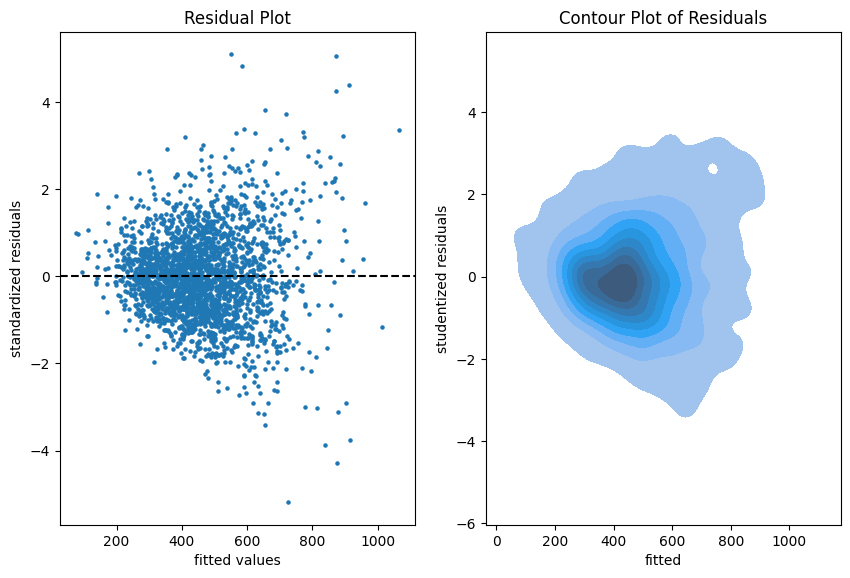

In [9]:
import seaborn as sns
fig, axes = plt.subplots(ncols=2, figsize=(4.8 * 2.1, 6.4))
ax = residual_plot(model=lm, X=X_train, y=y_train, ax=axes[0])
sns.kdeplot(
    x=lm.predict(X_train),
    y=residuals(lm, X_train, y_train, kind="studentized"),
    thresh=.02,
    fill=True,
    ax=axes[1],
).set(
    xlabel="fitted",
    ylabel="studentized residuals",
    title="Contour Plot of Residuals",
)

The more datapoints one has the less informative is a scatter plot.
Therefore, we put a contour plot on the right.

Visual insights:
- There seems to be a larger variability for larger fitted values.
  This is a hint that the homoscedascity might be violated.
- The residuals seem to be centered around 0.
  This is a hint that the model is well calibrated (adequate).

<Axes: title={'center': 'Q-Q plot of studentized residuals'}, xlabel='theoretical quantiles', ylabel='ordered values (studentized residuals)'>

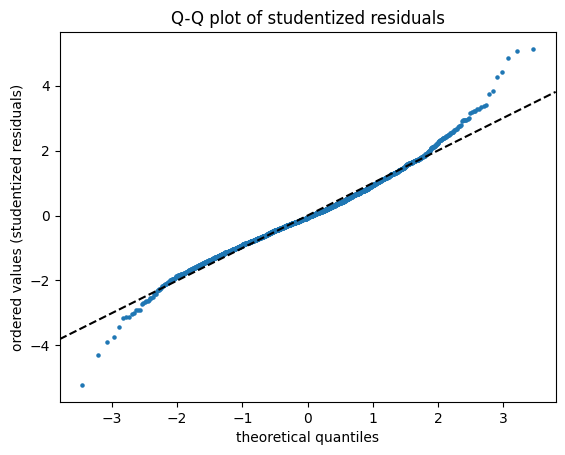

In [10]:
qq_plot(lm, X_train, y_train)

The QQ-plot shows the quantiles of the theoretical assumed distribution of the residuals on the x-axis and the ordered values of the residuals on the y-axis.
We decided to use the studentized residuals because normality of the error implies a student (t) distribution for these residuals.

Concluding remarks:
- We might do similar plots on the test sample, but we don't necessarily need a test sample to answer the inference questions.
- It is good practice to plot the residuals vs each of the features as well.

## 3. Diagnostics for Prediction
If we are only interested in predictions of the mean rent, $\hat{E}[Y]$, we don't care much about the probability distribution of $Y$.
We just want to know if the predictions are close enough to the real mean of the rent $E[Y]$.
In a similar argument as for the error term and residuals, we have to accept that $E[Y]$ is not observable (it is the quantity that we want to predict).
So we have to fall back to the observations of $Y$ in order to judge if our model is well calibrated, i.e., close the the ideal $E[Y]$.

Very importantly, here we make use of the test sample in all of our diagnostics because **we fear the in-sample bias**.

We start simple by a look at the unconditional calibration, that is the average (negative) residual $\frac{1}{n}\sum(\hat{E}[Y_i]-Y_i)$.

In [11]:
compute_bias(
    y_obs=np.concatenate([y_train, y_test]),
    y_pred=lm.predict(pd.concat([X_train, X_test])),
    feature=np.array(["train"] * X_train.shape[0] + ["test"] * X_test.shape[0]),
)

feature,bias_mean,bias_count,bias_weights,bias_stderr,p_value
str,f64,u32,f64,f64,f64
"""test""",2.087626,617,617.0,5.784786,0.718311
"""train""",-3.0740e-12,2465,2465.0,2.808331,1.0


It is no suprise that `bias_mean` in the train set is almost zero.
This is a property of (generalized) linear model (with intercept term).
On the test set, however, we detect a small bias of about 2 EUR per appartment on average.

Next, we have a look a reliability diagrams which contain much more information about calibration and bias of a model than the unconditional calibration above.
In fact, it assesses auto-calibration, i.e. how well does the model use its own information.
An ideal model would lie on the dotted diagonal line.

Text(0.5, 1.0, 'Reliability Diagram test set (n=617)')

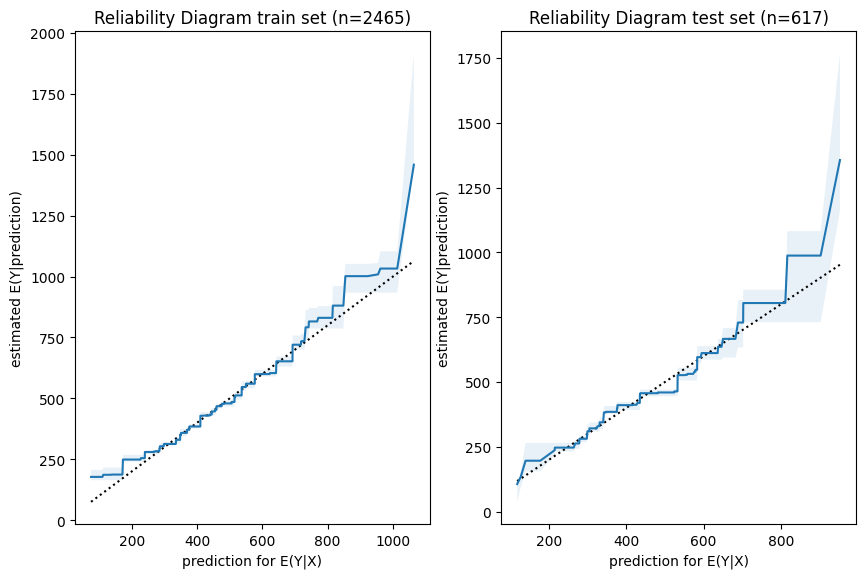

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(4.8 * 2.1, 6.4))
plot_reliability_diagram(y_obs=y_train, y_pred=lm.predict(X_train), n_bootstrap=100, ax=axes[0])
axes[0].set_title(axes[0].get_title() + f" train set (n={X_train.shape[0]})")
plot_reliability_diagram(y_obs=y_test, y_pred=lm.predict(X_test), n_bootstrap=100, ax=axes[1])
axes[1].set_title(axes[1].get_title() + f" test set (n={X_test.shape[0]})")

Visual insights:
- Graphs on train and test set look very similar.
  The larger uncertainty intervals on the test set stem from the fact that is has a smaller sample size.
- The model seems to lie around the diagonal indicating good auto-calibration for the largest range.
- Very high predicted values seem to be systematically too low, i.e. the graph is above the diagonal.

Finally, we assess conditional calibration, i.e. the calibration with respect to the features.
Therefore, we plot our favorite graph for each feature wich consists of:
- average observed value of $Y$ for each (binned) value of the feature
- average predicted value
- partial dependence
- histogram of the feature (grey, right y-axis)

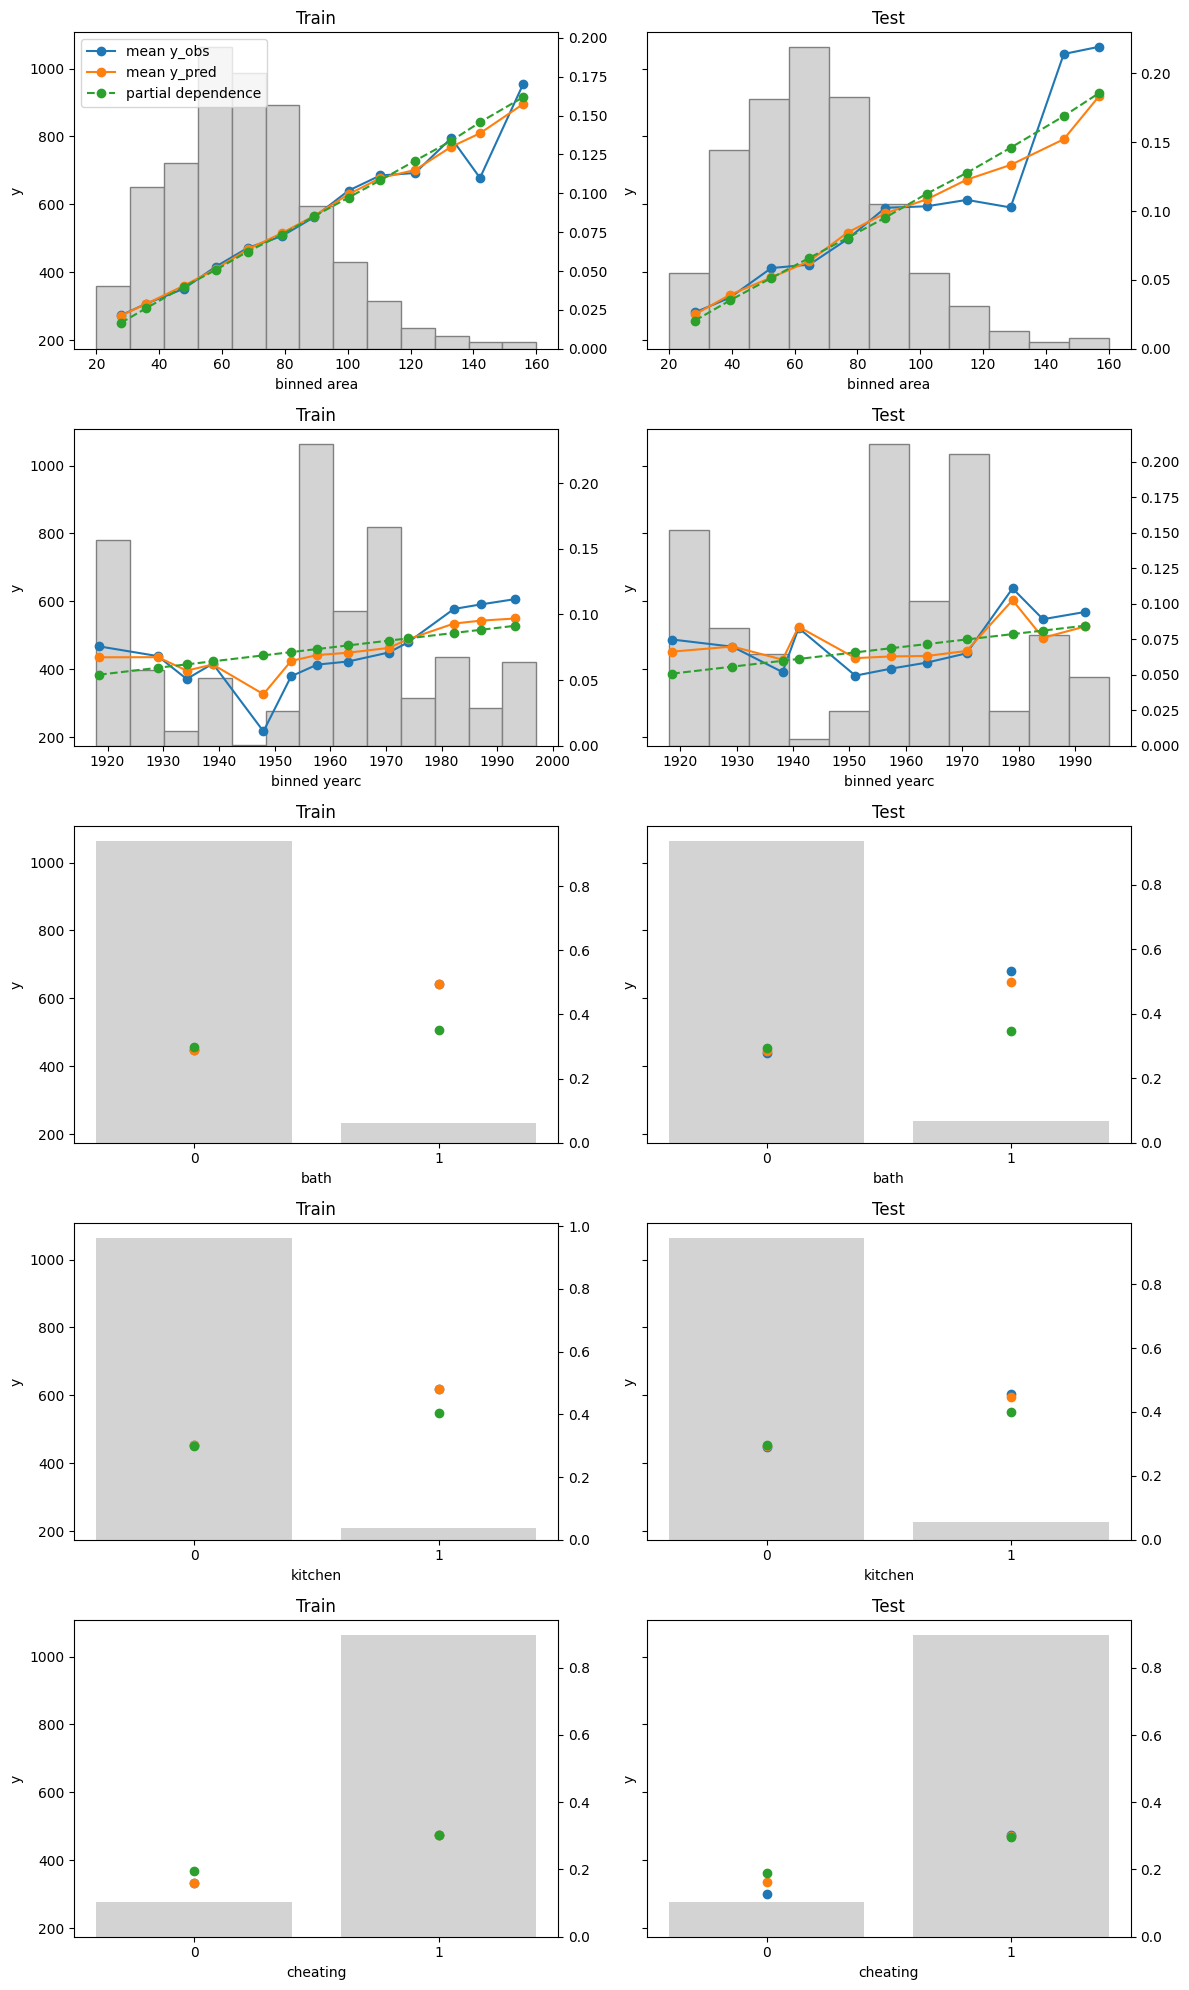

In [13]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 5*4), sharey=True)
for i, col in enumerate(["area", "yearc", "bath", "kitchen", "cheating"]):
    plot_marginal(
        y_obs=y_train,
        y_pred=lm.predict(X_train),
        X=X_train,
        feature_name=col,
        predict_function=lm.predict,
        ax=axes[i][0],
    )
    plot_marginal(
        y_obs=y_test,
        y_pred=lm.predict(X_test),
        X=X_test,
        feature_name=col,
        predict_function=lm.predict,
        ax=axes[i][1],
    )
    axes[i][0].set_title("Train")
    axes[i][1].set_title("Test")
    if i != 0:
        axes[i][0].get_legend().remove()
    axes[i][1].get_legend().remove()
fig.tight_layout()

Visual insights:
- On the train set, the categorical features seem to have perfect calibration as average observed equals average predicted.
  This is again a result of the balance property.
  On the test set, we see a deviation, especially for the categorical level with smaller sample size.
  This is a good demonstration why plotting on both train and test set is a good idea.
- The numerical features area and year of construction seem fine, but a close look can't hurt.

We next perfom a bias plot, which is plotting the average difference of predicted minus observed per feature value.
The values should be around zero, so we can zoom in on the y-axis.
This is very similar to the residual plot, but the information is better condensed for its purpose.

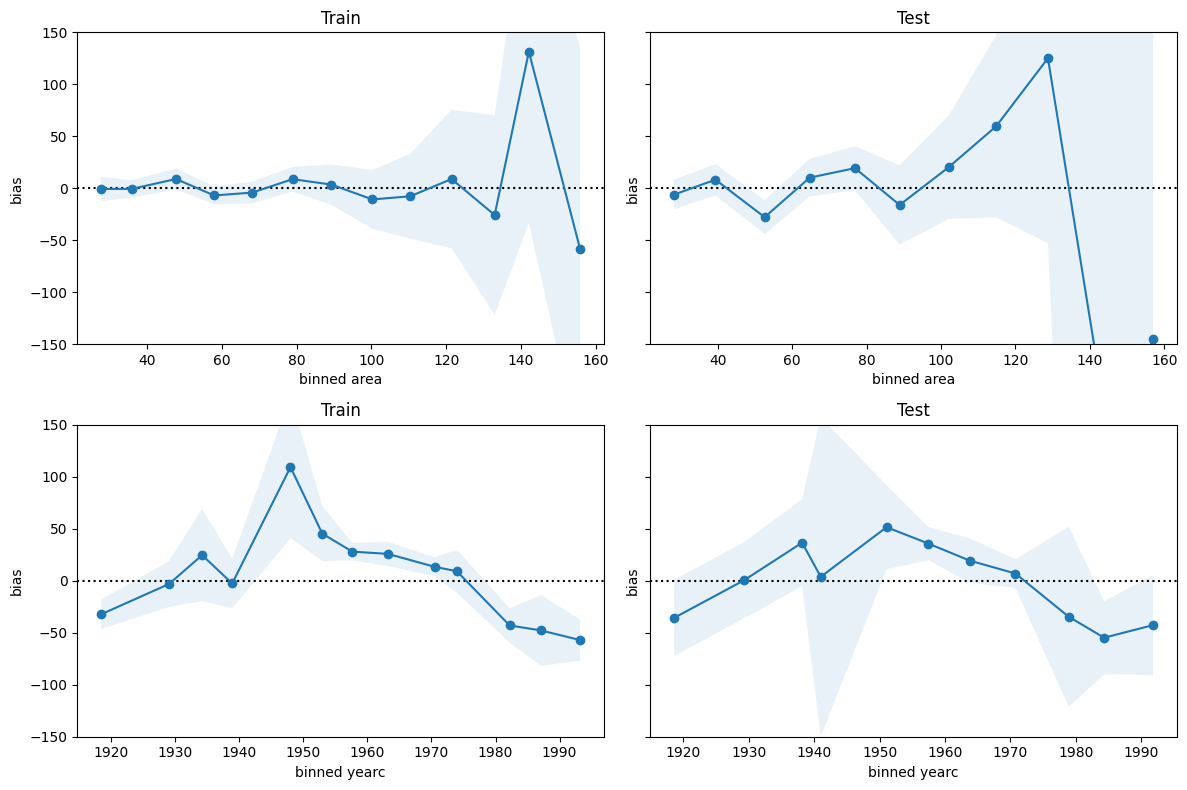

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 2*4), sharey=True)
axes[0,0].set_ylim(-150, 150)
for i, col in enumerate(["area", "yearc"]):
    plot_bias(
        y_obs=y_train,
        y_pred=lm.predict(X_train),
        feature=X_train[col],
        ax=axes[i][0],
    )
    plot_bias(
        y_obs=y_test,
        y_pred=lm.predict(X_test),
        feature=X_test[col],
        ax=axes[i][1],
    )
    axes[i][0].set_title("Train")
    axes[i][1].set_title("Test")
fig.tight_layout()

Visual insights:
- For large values of `area` and `yearc` in the 1940s and 1950s, there are only few observations available.
  Still, the model might be improved for those regions.
- The bias of `yearc` shows a parabolic curve.
  The simple linear effect in our model seems too simplistic.
  A refined model could use splines instead, as for `area`.

Concluding remarks:
- The predictions for `area` larger than around 120 square meters and for year of construction around the 2nd world war are less reliable.
- For all the rest, the bias is smaller than 50 EUR on average.
  This is therefore a rough estimation of the prediction uncertainty.
  It should be enough to prevent improperly high (or low) rents (on average).